In [1]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [2]:
# For colab
# from google.colab import drive
# drive.mount('/content/drive')

# !pip uninstall scikit-learn

# import sys
# sys.path.append('/content/drive/My Drive/colab/')
# sys.path.append('/content/drive/My Drive/colab/scikit-learn')
# #print(sys.path)

# import sklearn
# #sklearn.show_versions()

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.ensemble import RandomForestRegressor 
import regression_common

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

np.random.seed(39)

Using TensorFlow backend.


In [4]:
# load lesion load matrix 
lesion_load_matrix = np.load(DATA_DIR + 'lesions_load_matrix_absolute.npy')
print(lesion_load_matrix.shape)

# take log of lesion loads
lesion_load_df = pd.DataFrame(lesion_load_matrix)
lesion_load_log_df = np.log(1+lesion_load_df)

(1401, 144)


In [5]:
#patient_df.to_hdf(DATA_DIR + 'patients.h5', key='p', mode='w')
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')

## Multitask Analysis

In [6]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(lesion_load_log_df)

In [7]:
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Multitask Ridge

In [8]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.001)
    alpha = np.linspace(0, 10, 51)
    my_grid={"alpha": alpha}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [9]:
scores_mr = perform_multitask_ridge(X, Y)

Performing Multitask Ridge regression (5-fold nested CV)

Fold-1: Best params: {'alpha': 4.6000000000000005}

Fold-2: Best params: {'alpha': 5.6000000000000005}

Fold-3: Best params: {'alpha': 4.800000000000001}

Fold-4: Best params: {'alpha': 4.2}

Fold-5: Best params: {'alpha': 4.800000000000001}


### PLS

In [10]:
def perform_pls_regression(X, Y):
    print('Performing PLS regression (5-fold nested CV)')
    estimator = PLSRegression()
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [11]:
scores_pls = perform_pls_regression(X, Y)

Performing PLS regression (5-fold nested CV)

Fold-1: Best params: {'n_components': 2}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 2}


### CCA

In [12]:
def perform_cca(X, Y):
    print('Performing CCA (5-fold nested CV)')
    estimator = CCA(n_components=6)
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [13]:
scores_cca = perform_cca(X, Y)

Performing CCA (5-fold nested CV)

Fold-1: Best params: {'n_components': 1}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 1}


### Random Forest Regression

In [14]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [10, 100, 500, 1000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2, 5, 10, 50, 100, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    max_samples = [0.4, 0.5, 0.7, 0.8]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True)

In [15]:
scores_rf = perform_random_forest_regr(X, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-2: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-3: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-4: Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.4, 'max_features': 'log2', 'max_depth': 10}

Fold-5: Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 10}


### Neural Net

In [32]:
def build_model(l1_units, l2_units, l3_units, lr, l2_reg):
    model = Sequential()
    model.add(Dense(l1_units, input_dim=X.shape[1], activation='relu', kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l2_units, activation='relu', kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l3_units, activation='relu', kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(Y.shape[1], activation=None, kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    adam = Adam(lr=lr)
    model.compile(loss='mse', metrics=['mae'], optimizer=adam)
    return model

def perform_nn_regression(X, Y):

    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
    estimator = KerasRegressor(build_fn=build_model, epochs=100, verbose=0)

    lr = [0.005, 0.002, 0.001, 0.0008, 0.0001]
    l1_units = [30]
    l2_units = [20]
    l3_units = [10]
    l2_reg = [0.20, 0.15, 0.10, 0.05, 0.01, 0.005, 0.001, 0.0001, 0.0]
    batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256]

    my_grid = {'l1_units': l1_units,
               'l2_units': l2_units,
               'l3_units': l3_units,
               'lr': lr,
               'l2_reg': l2_reg,
               'batch_size': batch_size}

    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True, \
                                                nn=True, callbacks=[es], n_jobs=-1, print_r2=True)

In [ ]:
scores_nn = perform_nn_regression(X, Y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fold-1: Best params: {'lr': 0.0001, 'l3_units': 10, 'l2_units': 20, 'l2_reg': 0.0001, 'l1_units': 30, 'batch_size': 16, 'epochs': 12}
[0.11489917 0.0308258  0.00530466 0.06188711 0.00143732 0.00162622]
[-0.05392906 -0.10663244 -0.01052702 -0.10234151 -0.00052653 -0.00049818]
Fold-2: Best params: {'lr': 0.0008, 'l3_units': 10, 'l2_units': 20, 'l2_reg': 0.0, 'l1_units': 30, 'batch_size': 32, 'epochs': 4}
[0.12803069 0.0523921  0.00390511 0.07630066 0.00170726 0.00043176]
[-0.21270252 -0.19282406 -0.00648578 -0.07435979 -0.00048697 -0.01366754]
Fold-3: Best params: {'lr': 0.0008, 'l3_units': 10, 'l2_units': 20, 'l2_reg': 0.0001, 'l1_units': 30, 'batch_size': 2, 'epochs': 3}
[0.15860238 0.08401378 0.03100795 0.11069059 0.01102012 0.0141145 ]
[ 0.08819558 -0.09684635 -0.0448821   0.00838508 -0.01002715 -0.0345475 ]


In [8]:
def build_model_linear(l1_units, l2_units, l3_units, lr, l2_reg):
    model = Sequential()
    model.add(Dense(l1_units, input_dim=X.shape[1], activation=None, kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l2_units, activation=None, kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l3_units, activation=None, kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(Y.shape[1], activation=None, kernel_initializer='truncated_normal', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    adam = Adam(lr=lr)
    model.compile(loss='mse', metrics=['mae'], optimizer=adam)
    return model

def perform_nn_linear_regression(X, Y):

    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
    estimator = KerasRegressor(build_fn=build_model_linear, epochs=100, verbose=0)

    lr = [0.005, 0.002, 0.001, 0.0008, 0.0005, 0.0001, 0.00005, 0.00001]
    l1_units = [25]
    l2_units = [15]
    l3_units = [10]
    l2_reg = [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.00]
    batch_size = [1, 2, 4, 8, 16, 32, 64]

    my_grid = {'l1_units': l1_units,
               'l2_units': l2_units,
               'l3_units': l3_units,
               'lr': lr,
               'l2_reg': l2_reg,
               'batch_size': batch_size}

    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True, \
                                                nn=True, callbacks=[es], n_jobs=-1, print_r2=True)

In [9]:
scores_nn_linear = perform_nn_linear_regression(X, Y)
# plot_scores(scores_nn_linear)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fold-1: Best params: {'lr': 0.0001, 'l3_units': 10, 'l2_units': 15, 'l2_reg': 1e-06, 'l1_units': 25, 'batch_size': 4, 'epochs': 6}
[0.12084762 0.03592608 0.01927905 0.07079622 0.00973281 0.0072076 ]
[-0.00853916 -0.07762323 -0.00517602 -0.05852487 -0.00278835 -0.00115884]
Fold-2: Best params: {'lr': 0.0001, 'l3_units': 10, 'l2_units': 15, 'l2_reg': 1e-06, 'l1_units': 25, 'batch_size': 4, 'epochs': 7}
[0.1314932  0.04382993 0.0022391  0.07574312 0.00080907 0.00081191]
[-0.15716208 -0.15675044 -0.00522129 -0.04947077 -0.00091294 -0.01239962]
Fold-3: Best params: {'lr': 0.0001, 'l3_units': 10, 'l2_units': 15, 'l2_reg': 1e-06, 'l1_units': 25, 'batch_size': 4, 'epochs': 8}
[0.11272214 0.05905866 0.00934162 0.07852911 0.00143989 0.00532322]
[ 0.11736618 -0.05570235 -0.01311606  0.02841707 -0.00271004 -0.01174882]
Fold-4: Best params: {'lr': 0.0001, 'l3_units': 10, 'l2_units

NameError: name 'plot_scores' is not defined

In [16]:
# organize and plot results

scores_all_models = pd.DataFrame()

scores_mr.insert(0, "Model", "Multitask Ridge")
scores_pls.insert(0, "Model", "PLS")
scores_cca.insert(0, "Model", "CCA")
scores_rf.insert(0, "Model", "Random Forest")
scores_nn.insert(0, "Model", "Neural Network")
scores_nn_linear.insert(0, "Model", "Neural Network (Linear)")

scores_all_models = pd.concat([scores_mr, scores_pls, scores_cca, scores_rf, scores_nn, scores_nn_linear], ignore_index=True)

In [15]:
# persist results
scores_all_models.to_hdf(DATA_DIR + 'results_atlas_multioutput.h5', key='p', mode='w')
# scores_all_models = pd.read_hdf(DATA_DIR + 'results_atlas_multioutput.h5', key='p')

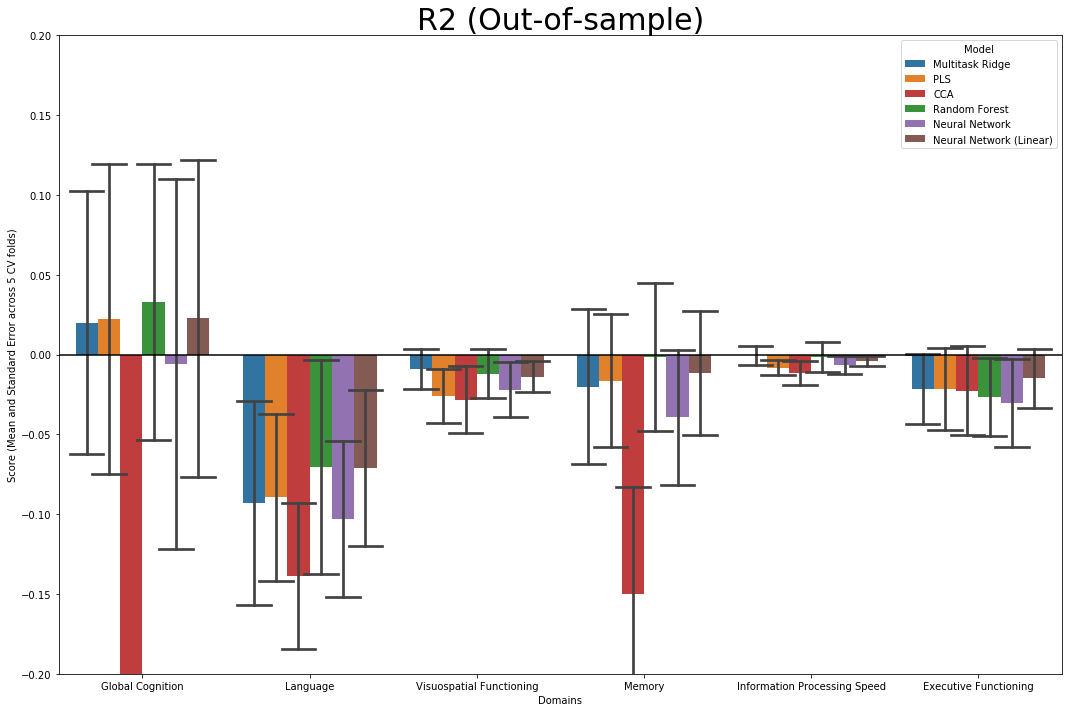

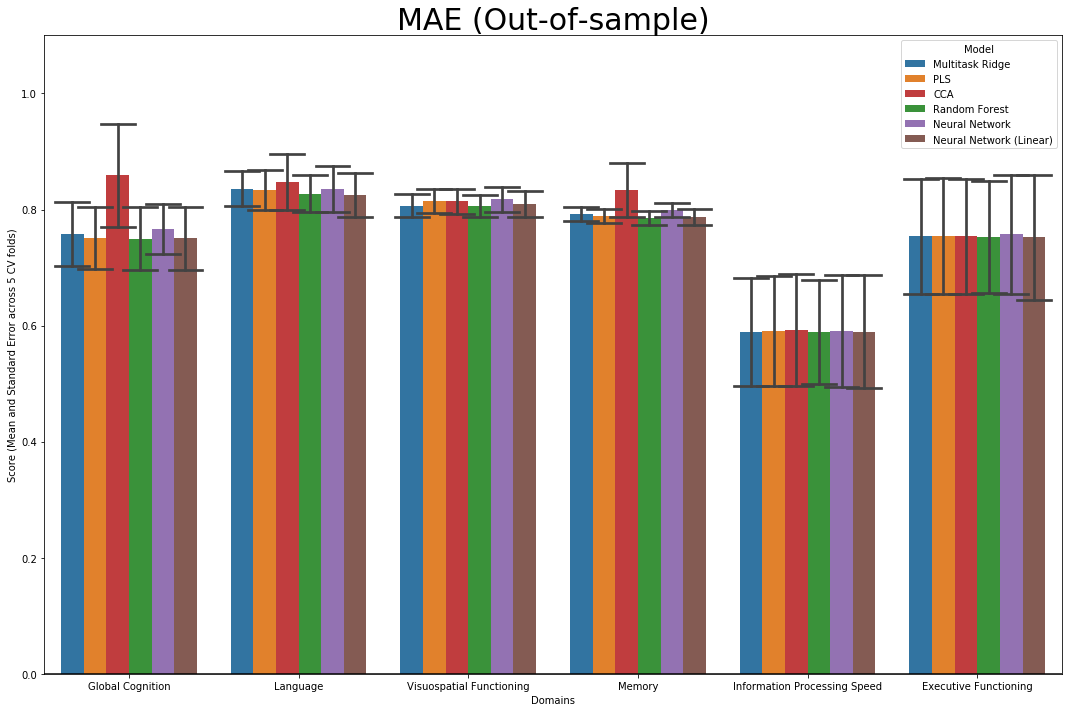

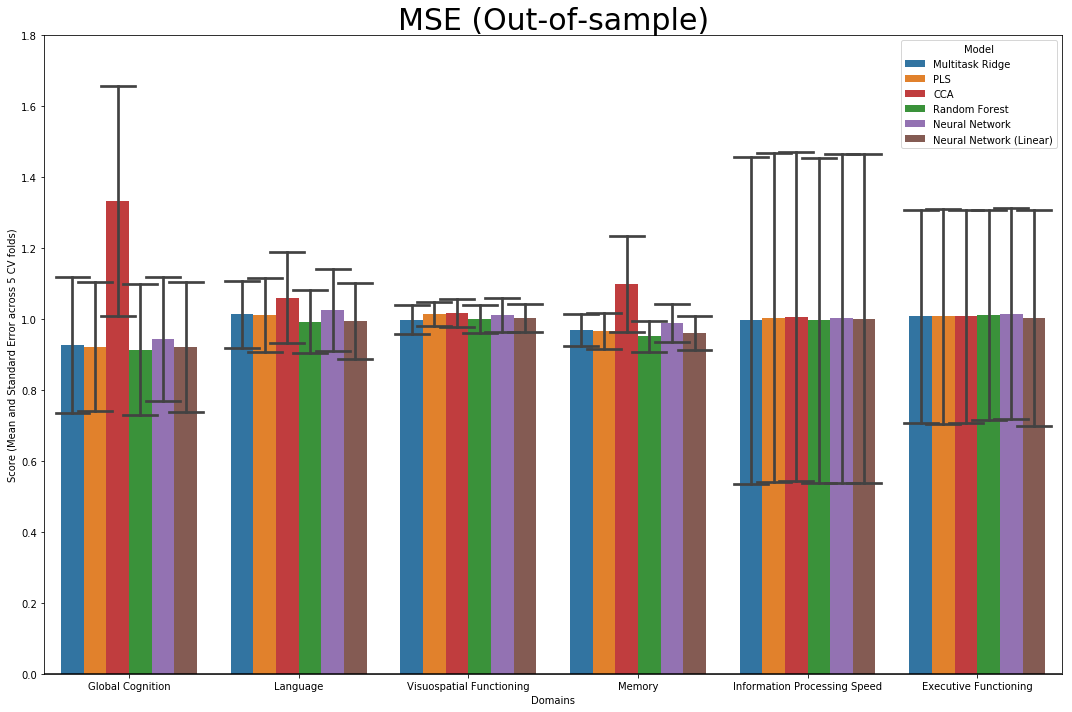

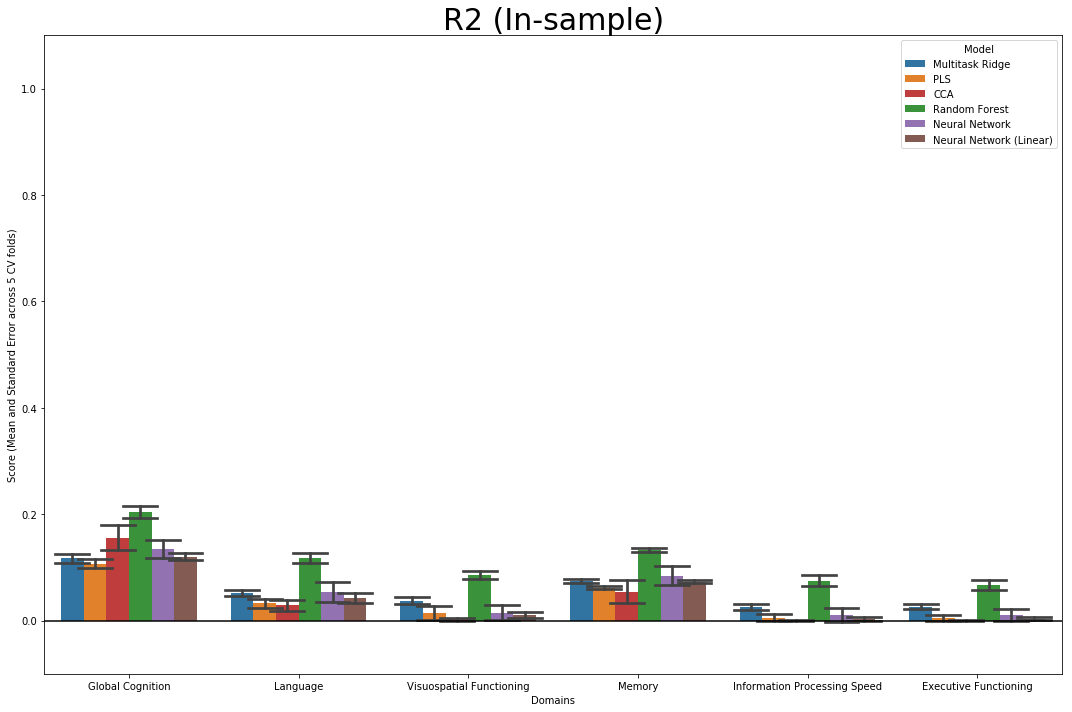

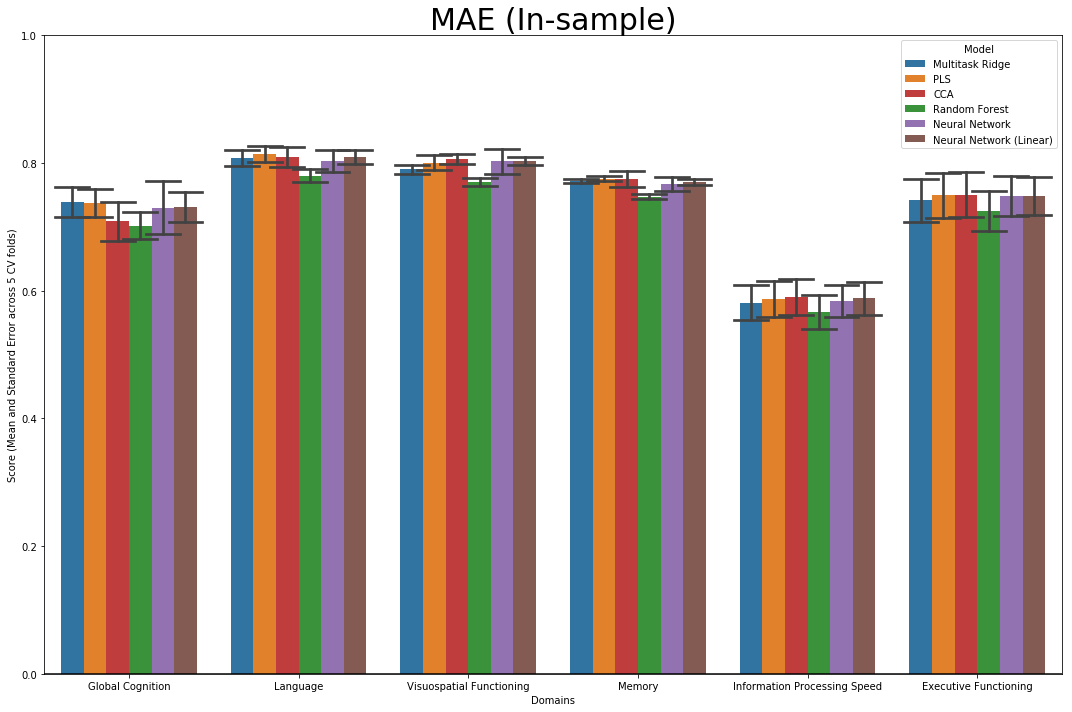

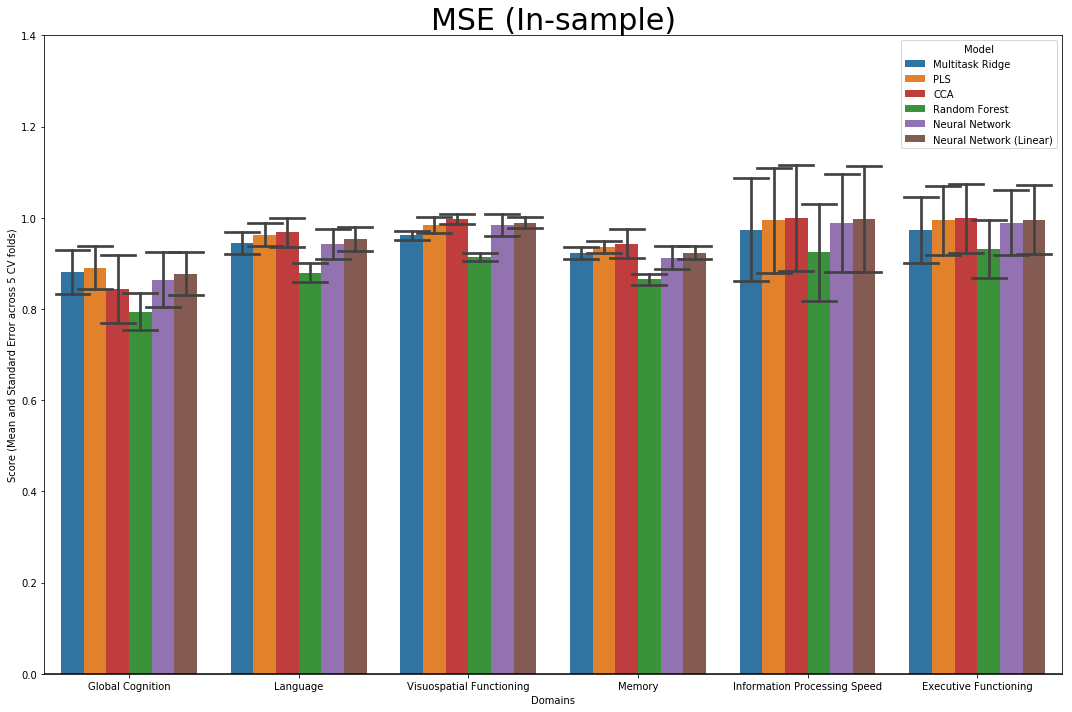

In [22]:
regression_common.plot_all_scores(scores_all_models, hue_order=['Multitask Ridge', 'PLS', 'CCA', 'Random Forest', 
                                                                'Neural Network', 'Neural Network (Linear)'])